In [118]:
from carbon import CarbonSimulatorUI, CarbonOrderUI, P, __version__, __date__
from math import sqrt, exp, log
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('seaborn-dark')
plt.rcParams['figure.figsize'] = [12,6]
from dataclasses import dataclass
from time import time as timestamp
from os.path import join as j
import os
print(f"Carbon v{__version__} ({__date__})")
print("{0.__name__} v{0.__VERSION__} ({0.__DATE__})".format(CarbonSimulatorUI))
print("{0.__name__} v{0.__VERSION__} ({0.__DATE__})".format(CarbonOrderUI))

Carbon v2.3-BETA0 (21/Jan/2022)
CarbonSimulatorUI v2.4 (12/Jan/2023)
CarbonOrderUI v1.6.1 (21/Jan/2023)


# Carbon Simulation - Demo 7-3 (frozen data)

## Setup

In [119]:
DATAPATH = "../data"
DATAID = "RANPTH-05000-0000"
DATAFN = j(DATAPATH, f"{DATAID}.pickle")
DATAFN

'../data/RANPTH-05000-0000.pickle'

In [120]:
#!ls {DATAPATH}

In [121]:
OUTPATH = "/Users/skl/Desktop/sim7-3"
OUTPATH = None
if OUTPATH:
    !mkdir {OUTPATH}
    !rm {OUTPATH}/*.png

mkdir: /Users/skl/Desktop/sim7-3: File exists
zsh:1: no matches found: /Users/skl/Desktop/sim7-3/*.png


## Code

### Data retrieval

In [122]:
def dfread(fn):
    """reads dataframe from file and asserts format"""
    
    if fn[-7:] == ".pickle":
        df = pd.read_pickle(fn)
    else:
        df = pd.read_csv(fn)
    assert df.columns[0] == "time"
    assert df.columns[1] == "datetime"
    return df
    
def pdread(fn, datacol=None, indexcol=None):
    """
    reads a dataframe and returns a single column with index
    
    :fn:        the (full) filename
    :datacol:   name or index of the data col; None returns frame
    :indexcol:  name of the index col (default: "datetime")
    :returns:   pandas series
    """
    if indexcol is None: indexcol = "datetime"

    df = dfread(fn)
    df = df.set_index(indexcol)
    if datacol is None:
        return df.iloc[:, 1:]
    elif isinstance(datacol, str):
        return df[datacol]
    elif isinstance(datacol, int):
        return df.iloc[:, datacol+1]
    else:
        raise ValueError("datacol must be None, str or int", datacol)

def pdcols(fn):
    """
    reads a dataframe and returns a single column with index
    
    :fn:        the (full) filename
    :returns:   the column names (excluding the first two)
    """
    return dfread(fn).columns[2:]

def pathtime(path):
    """returns the time (in years) covered by the series `path`"""
    return (path.index[-1]-path.index[0])/pd.Timedelta(days=1)/365.25

### Strategy encapsulation

In [123]:
@dataclass
class strategy():
    
    p_buy_a: float
    p_buy_b: float
    p_sell_a: float
    p_sell_b: float 

    amt_rsk: float = 0
    amt_csh: float = 0
        
    rsk: str = "RSK"
    csh: str = "CSH"

    @classmethod
    def from_mwh(cls, mid, gap, width, amt_rsk=0, amt_csh=0, rsk="RSK", csh="CSH"):
        """create class from mid and widths"""
        p_buy_a = mid/(1+gap)
        p_buy_b = mid/(1+gap)/(1+width)
        p_sell_a = mid*(1+gap)
        p_sell_b = mid*(1+gap)*(1+width)
        return cls(p_buy_a, p_buy_b, p_sell_a, p_sell_b, amt_rsk, amt_csh, rsk, csh)
    
    @property
    def descr(s):
        bid_s = f"BID {s.p_buy_b:.1f}-{s.p_buy_a:.1f} [{s.amt_csh} {s.csh}]"
        ask_s = f"ASK {s.p_sell_a:.1f}-{s.p_sell_b:.1f} [{s.amt_rsk} {s.rsk}]"
        return f"{bid_s} -- {ask_s}"
    
    @property
    def p(s):
        """returns a tuple suitable for `add_strategy (*params)`"""
        return (s.rsk, s.amt_rsk, s.p_sell_a, s.p_sell_b, s.amt_csh, s.p_buy_a, s.p_buy_b)
    
    @property
    def slashpair(self):
        return f"{self.rsk}/{self.csh}"

strategy.from_mwh(2000, 0.1, 0.05, amt_rsk=1, rsk="ETH", csh="USD").p

('ETH', 1, 2200.0, 2310.0, 0, 1818.181818181818, 1731.6017316017314)

## Set strategies

In [124]:
strats = (
    strategy.from_mwh(100, 0.1, 0.05, amt_rsk=1, amt_csh=0),
    strategy.from_mwh(100, 0.2, 0.05, amt_rsk=1, amt_csh=0),
    strategy.from_mwh(100, 0.1, 0.2, amt_rsk=1, amt_csh=0),
    strategy.from_mwh(100, 0.2, 0.2, amt_rsk=1, amt_csh=0),
)

## Simulation

In [125]:
def run_sim(strat, path):
    """
    runs a simulation 
    
    :strat:    the `strategy` object
    :path:     simulation path (pandas or numpy series)
    :returns:  tuple(rskamt_r, cshamt_r, value_r)
    """
    Sim = CarbonSimulatorUI(pair=strat.slashpair)
    Sim.add_strategy(*strat.p)
    #print(strat.p)

    ouis = Sim.state()["orderuis"]
    rskamt_r  = [ouis[0].y]
    cshamt_r = [ouis[1].y]
    for spot in path[1:]:
        #print(spot)
        for oui in ouis.values():
            oui.tradeto(spot)
        rskamt_r  += [ouis[0].y]
        cshamt_r += [ouis[1].y]
    
    value_r = rskamt_r * path + cshamt_r
    return rskamt_r, cshamt_r, value_r 

In [126]:
def plot_sim(strat, rskamt_f, cshamt_r, value_r, dataid):
    """
    plots the chart
    """
    
    rskamt_f  = rskamt_r[-1]
    cshamt_f  = cshamt_r[-1]

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    plots = []
    plots += ax1.plot(path, color="0.7", label="price")
    plots += [ax1.fill_between(path.index, strat.p_buy_a, strat.p_buy_b, color="lightgreen", alpha=0.1, label="bid range")]
    plots += [ax1.fill_between(path.index, strat.p_sell_a, strat.p_sell_b, color="lightcoral", alpha=0.1, label="ask range")]
    plots += ax2.plot(value_r, color = "blue", label="value [rhs]")
    ax2.set_ylabel("portfolio value (USDC)")
    ax1.set_ylabel("price")
    ax1.set_xlabel("date")
    plt.title(f"{strat.descr} on {dataid}")
    labels = [p.get_label() for p in plots]
    plt.legend(plots, labels)
    #print(f"t={   0:3.1f}: {rskamt_r[ 0]:5.1f} ETH {cshamt_r[ 0]:8.1f} USDC (value = {value_r[ 0]:6.1f} USDC)")
    #print(f"t={time:3.1f}: {rskamt_r[-1]:5.1f} ETH {cshamt_r[-1]:8.1f} USDC (value = {value_r[-1]:6.1f} USDC)")
    

Saving figure /Users/skl/Desktop/sim7-3/RANPTH-05000-0000-p0000-0.png


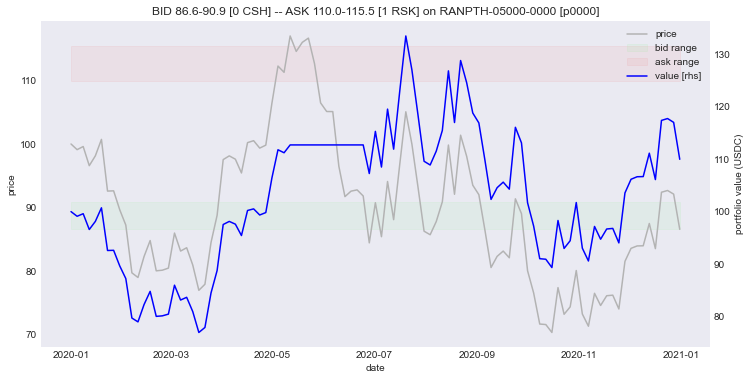

Saving figure /Users/skl/Desktop/sim7-3/RANPTH-05000-0000-p0000-1.png


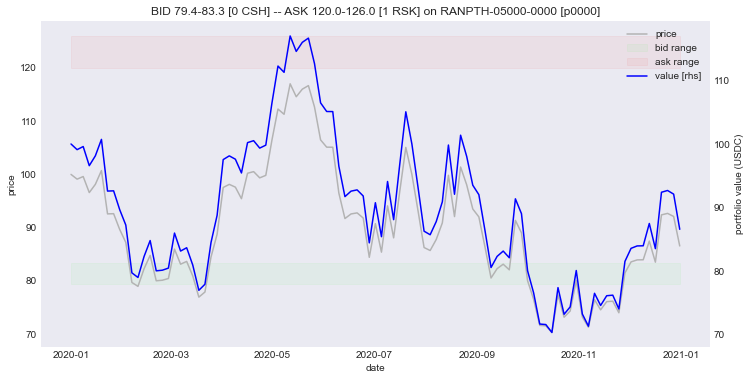

Saving figure /Users/skl/Desktop/sim7-3/RANPTH-05000-0000-p0000-2.png


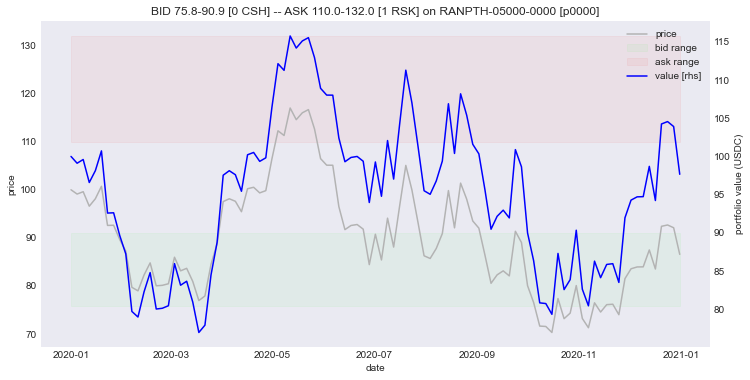

Saving figure /Users/skl/Desktop/sim7-3/RANPTH-05000-0000-p0000-3.png


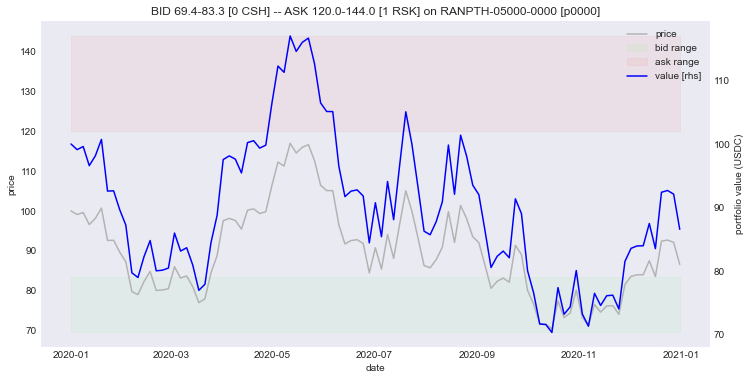

Saving figure /Users/skl/Desktop/sim7-3/RANPTH-05000-0000-p0001-0.png


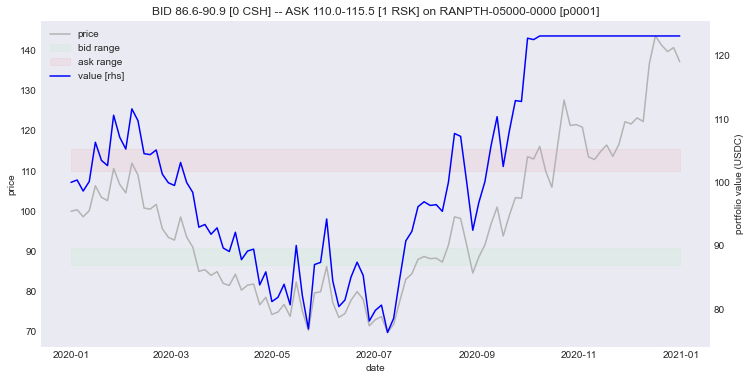

Saving figure /Users/skl/Desktop/sim7-3/RANPTH-05000-0000-p0001-1.png


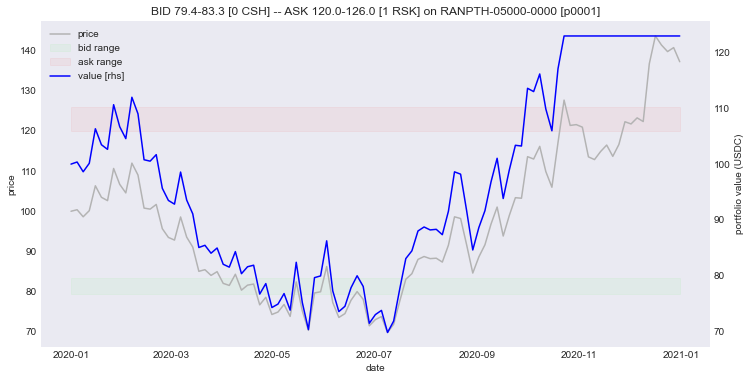

Saving figure /Users/skl/Desktop/sim7-3/RANPTH-05000-0000-p0001-2.png


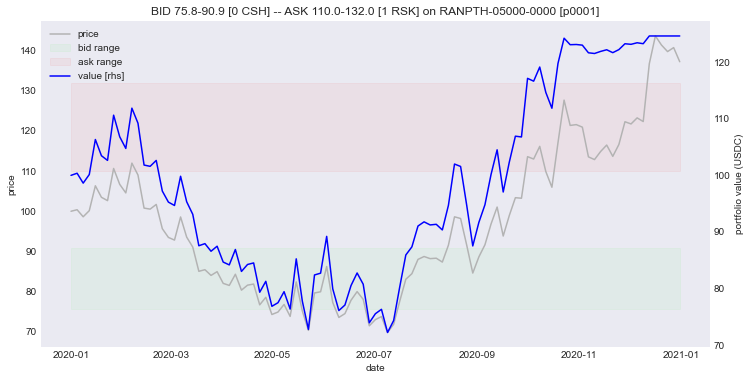

Saving figure /Users/skl/Desktop/sim7-3/RANPTH-05000-0000-p0001-3.png


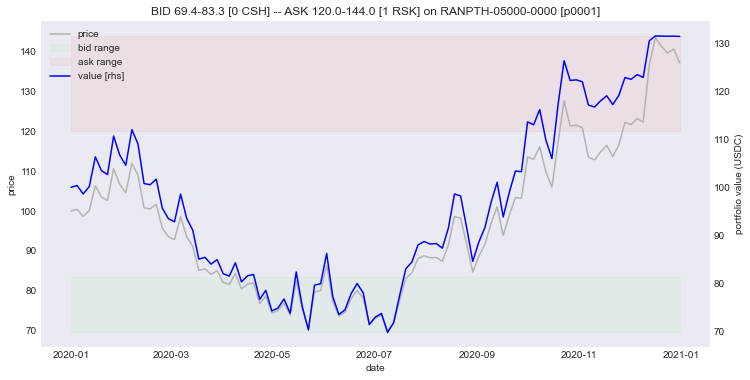

Saving figure /Users/skl/Desktop/sim7-3/RANPTH-05000-0000-p0002-0.png


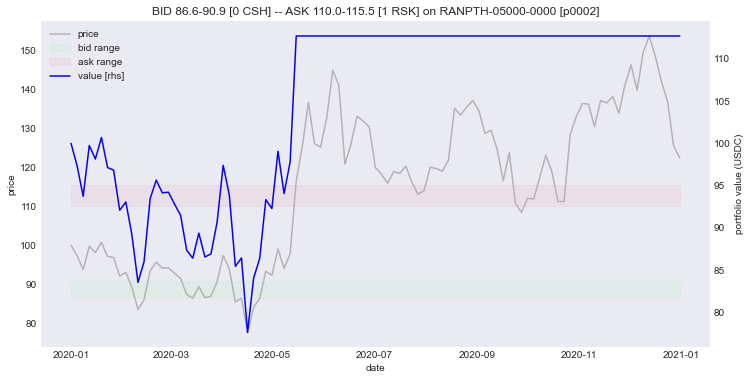

Saving figure /Users/skl/Desktop/sim7-3/RANPTH-05000-0000-p0002-1.png


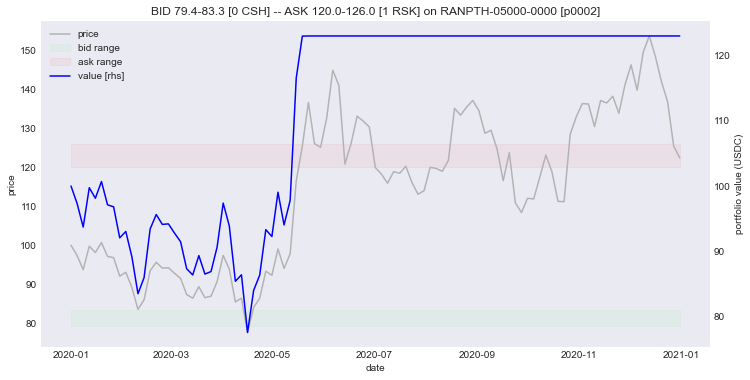

Saving figure /Users/skl/Desktop/sim7-3/RANPTH-05000-0000-p0002-2.png


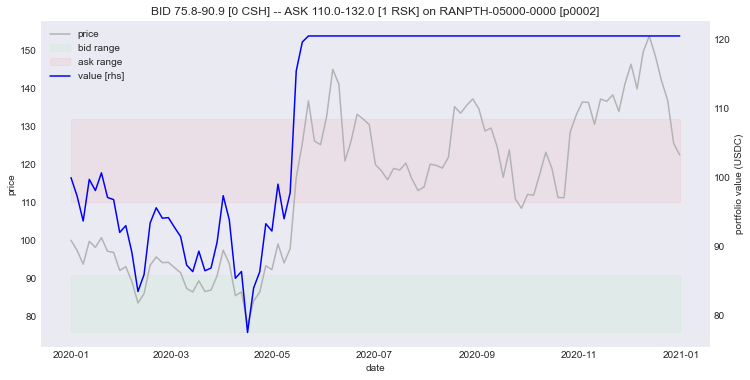

Saving figure /Users/skl/Desktop/sim7-3/RANPTH-05000-0000-p0002-3.png


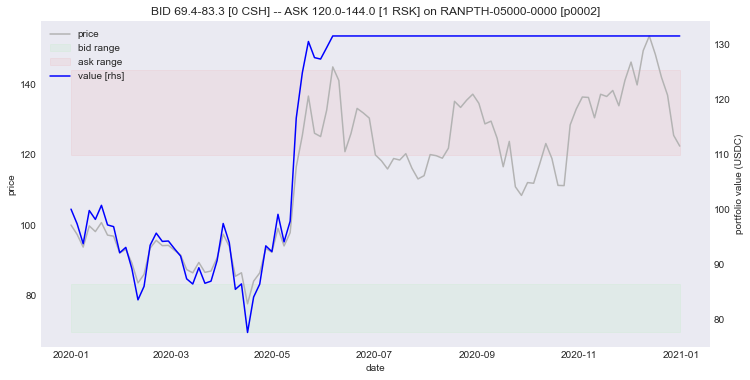

In [127]:
for colnm in ["p0000", "p0001", "p0002"]:
    for ix, strat in enumerate(strats):
    
        path = pdread(DATAFN, colnm)
        time = pathtime(path)

        rskamt_r, cshamt_r, value_r = run_sim(strat, path)
        plot_sim(strat, rskamt_r, cshamt_r, value_r, f"{DATAID} [{colnm}]")
        if OUTPATH:
            ffn = j(OUTPATH, f"{DATAID}-{colnm}-{ix}.png")
            print(f"Saving figure {ffn}")
            plt.savefig(ffn)
        plt.show()
        

In [128]:
if OUTPATH:
    !ls {OUTPATH}/*.png

/Users/skl/Desktop/sim7-3/RANPTH-05000-0000-p0000-0.png
/Users/skl/Desktop/sim7-3/RANPTH-05000-0000-p0000-1.png
/Users/skl/Desktop/sim7-3/RANPTH-05000-0000-p0000-2.png
/Users/skl/Desktop/sim7-3/RANPTH-05000-0000-p0000-3.png
/Users/skl/Desktop/sim7-3/RANPTH-05000-0000-p0001-0.png
/Users/skl/Desktop/sim7-3/RANPTH-05000-0000-p0001-1.png
/Users/skl/Desktop/sim7-3/RANPTH-05000-0000-p0001-2.png
/Users/skl/Desktop/sim7-3/RANPTH-05000-0000-p0001-3.png
/Users/skl/Desktop/sim7-3/RANPTH-05000-0000-p0002-0.png
/Users/skl/Desktop/sim7-3/RANPTH-05000-0000-p0002-1.png
/Users/skl/Desktop/sim7-3/RANPTH-05000-0000-p0002-2.png
/Users/skl/Desktop/sim7-3/RANPTH-05000-0000-p0002-3.png


In [129]:
if OUTPATH:
    from fls import fsave
    filelist = os.listdir(OUTPATH)
    filelist = [fn for fn in filelist if fn[-4:]==".png"]
    markdown = "\n\n".join(f"![]({OUTPATH}/{fn})" for fn in filelist)
    fsave(markdown, "_sim-charts.md", OUTPATH)
    !pandoc {OUTPATH}/_sim-charts.md -o {OUTPATH}/_sim-charts.docx

[fsave] Writing _sim-charts.md to /Users/skl/Desktop/sim7-3
